https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [1]:
from Database import db_mongo

from Utilities import clean_text

import string

db = db_mongo.db_mongo()

df = db.get_text_full_resume(100000000)

df = df.sample(frac=1).reset_index(drop=True)

df['text'] = df['text'].str.replace('\n',' ').replace('\x0c',' ')
 
df['text'] = [word for word in df['text'] if word not in string.punctuation]



Init DB


## Limpiar Texto

In [2]:
ct = clean_text.CleanText()

df['text'] = ct.cleanner_process(df["text"])

[nltk_data] Downloading package wordnet to /home/kguttas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _id     2484 non-null   object
 1   text    2484 non-null   object
 2   class   2484 non-null   object
dtypes: object(3)
memory usage: 58.3+ KB


In [4]:
df.describe()

,_id,text,class
count,2484,2484,2484
unique,2484,2482,24
top,96851e81-3e6c-4e09-9dbc-10805cd048b9,STOREKEEPER Professional Summary purpose this ...,BUSINESS-DEVELOPMENT
freq,1,2,120


In [5]:
df.head()

,_id,text,class
0,96851e81-3e6c-4e09-9dbc-10805cd048b9,DIGITAL CLIENT LEAD Experience Current Digital...,DIGITAL-MEDIA
1,fbde3c16-13c9-449a-ba5f-2bccc1eaf42e,SALES REPRESENTATIVE Professional Summary Hard...,SALES
2,6dd9a308-090a-400b-a3b7-d298632a0527,INFORMATION TECHNOLOGY SPECIALIST Career Overv...,INFORMATION-TECHNOLOGY
3,f3a8c4fd-4428-47a8-9deb-b1992f9a5c7e,CREATIVE DIRECTOR Career Focus Creative Direct...,ARTS
4,5feaeeb9-0d32-4076-b174-fcbe1021028d,CONSULTANT Professional Overview Masters Socia...,CONSULTANT


In [6]:
from io import StringIO
import pandas as pd

col = ['text', 'class']
df_new = df[col]
df_new = df_new[pd.notnull(df_new['text'])]
df_new.head()

,text,class
0,DIGITAL CLIENT LEAD Experience Current Digital...,DIGITAL-MEDIA
1,SALES REPRESENTATIVE Professional Summary Hard...,SALES
2,INFORMATION TECHNOLOGY SPECIALIST Career Overv...,INFORMATION-TECHNOLOGY
3,CREATIVE DIRECTOR Career Focus Creative Direct...,ARTS
4,CONSULTANT Professional Overview Masters Socia...,CONSULTANT


In [7]:
df_new.columns = ['text', 'class' ]
df_new['category_id'] = df_new['class'].factorize()[0]

category_id_df = df_new[['class', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'class']].values)

df_new.head()

,text,class,category_id
0,DIGITAL CLIENT LEAD Experience Current Digital...,DIGITAL-MEDIA,0
1,SALES REPRESENTATIVE Professional Summary Hard...,SALES,1
2,INFORMATION TECHNOLOGY SPECIALIST Career Overv...,INFORMATION-TECHNOLOGY,2
3,CREATIVE DIRECTOR Career Focus Creative Direct...,ARTS,3
4,CONSULTANT Professional Overview Masters Socia...,CONSULTANT,4


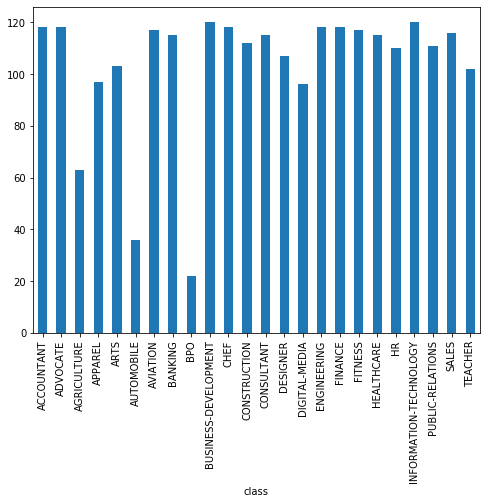

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_new.groupby('class').text.count().plot.bar(ylim=0)
plt.show()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.00001, norm='l2', 
                        encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df_new.text).toarray()
labels = df_new.category_id
features.shape

(2484, 682984)

In [10]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'ACCOUNTANT':
  . Most correlated unigrams:
. entries
. accountant
  . Most correlated bigrams:
. accountant company
. accountant summary
# 'ADVOCATE':
  . Most correlated unigrams:
. advocacy
. advocate
  . Most correlated bigrams:
. advocate company
. advocate summary
# 'AGRICULTURE':
  . Most correlated unigrams:
. agricultural
. agriculture
  . Most correlated bigrams:
. agriculture education
. natural resources
# 'APPAREL':
  . Most correlated unigrams:
. merchandising
. apparel
  . Most correlated bigrams:
. state apparel
. assistant buyer
# 'ARTS':
  . Most correlated unigrams:
. arts
. martial
  . Most correlated bigrams:
. language arts
. arts teacher
# 'AUTOMOBILE':
  . Most correlated unigrams:
. insureds
. automobile
  . Most correlated bigrams:
. liability claims
. special investigation
# 'AVIATION':
  . Most correlated unigrams:
. aircraft
. aviation
  . Most correlated bigrams:
. aviation supply
. aviation maintenance
# 'BANKING':
  . Most correlated unigrams:
. loan
.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_new['text'], df_new['class'], random_state = 0, shuffle= True)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [12]:
X_test.iloc[25]

'ACCOUNTANT Summary Experienced highly motivated work ethic with resultsdriven professionalism recognized commitment excellence demonstrates expertise communicating collaborating with peers clients Portrays excellent business acumen successfully provide accurate Accounts Receivables Collections Accounts Payable initiatives that achieves targeted company goals Selfmotivated professional able work independently team environment demonstrating broad based transferable qualifications Highlights Extensive knowledge Microsoft Windows computer systems operating system Proficient Microsoft Office Word Excel Power Point Basic experience with QuickBooks Enterprise Solutions SageMAS Software Peachtree Microsoft Access Account reconciliation expert General ledger accounting Flexible team player Experience Company Name January November Accountant City State Managed over million month revenue Accurately applied payments vendor accounts Researched resolved incorrect payments rejections other issues wi

In [13]:
print(clf.predict(count_vect.transform([X_test.iloc[25]])))

['ACCOUNTANT']


In [14]:
df_new[df_new['text'].str.contains(X_test.iloc[25])]

,text,class,category_id
1725,ACCOUNTANT Summary Experienced highly motivate...,ACCOUNTANT,7


In [15]:
print(clf.predict(count_vect.transform([X_test.iloc[38]])))

['ACCOUNTANT']


In [16]:
df_new[df_new['text'] == X_test.iloc[38]]

,text,class,category_id
1328,FINANCIAL ACCOUNTANT Summary Financial Account...,ACCOUNTANT,7


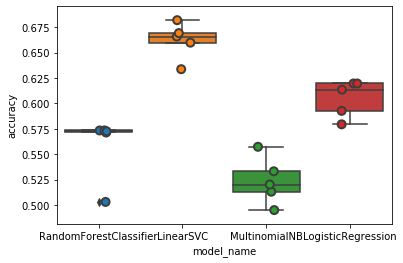

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [18]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.662241
LogisticRegression        0.605068
MultinomialNB             0.523751
RandomForestClassifier    0.558782
Name: accuracy, dtype: float64

In [19]:
category_id_df

,class,category_id
0,DIGITAL-MEDIA,0
1,SALES,1
2,INFORMATION-TECHNOLOGY,2
3,ARTS,3
4,CONSULTANT,4
5,BANKING,5
7,AVIATION,6
8,ACCOUNTANT,7
10,ADVOCATE,8
14,DESIGNER,9


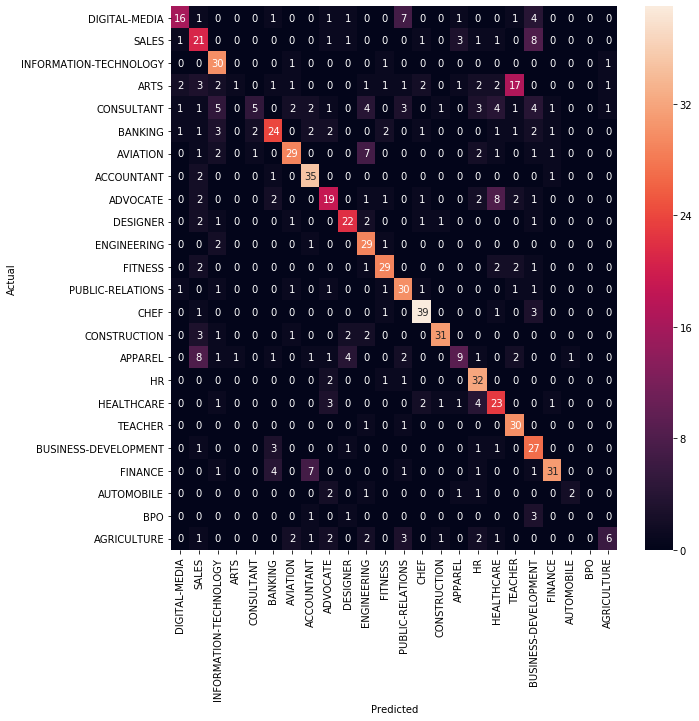

In [20]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_new.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df["class"].values, yticklabels=category_id_df["class"].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
from IPython.display import display

for predicted in category_id_df.category_id:
    
    for actual in category_id_df.category_id:
       
        if predicted != actual and conf_mat[actual, predicted] >= 5:
            
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['class', 'text']])
            print('')

'APPAREL' predicted as 'SALES' : 8 examples.


,class,text
1036,APPAREL,Rachel Guardado Summary Polished professional ...
621,APPAREL,STYLIST Objective internship opportunity under...
1647,APPAREL,HOLDER Summary Highly organized efficient mul...
778,APPAREL,APPAREL ASSOCIATE Summary organized detailorie...
194,APPAREL,GENERAL MANAGER Summary company that would off...
1988,APPAREL,CUSTOMER SERVICE MANAGER Summary Pleasant ener...
1450,APPAREL,CUSTOMER SERVICE SPECIALIST Summary Detailorie...
1079,APPAREL,CASHIER Professional Profile Responsible Cashi...



'CONSULTANT' predicted as 'INFORMATION-TECHNOLOGY' : 5 examples.


,class,text
425,CONSULTANT,CONSULTANT Summary Indepth knowledge understan...
1977,CONSULTANT,Pavithra Shetty Summary Customeroriented Princ...
2279,CONSULTANT,CONSULTANT Professional Summary Support Engin...
723,CONSULTANT,CONSULTANT Professional Summary Talented prof...
187,CONSULTANT,CONSULTANT Career Overview highly motivated te...



'FINANCE' predicted as 'ACCOUNTANT' : 7 examples.


,class,text
1739,FINANCE,FINANCE CUSTOMER CARE LEAD Summary Property Ma...
76,FINANCE,FINANCE OFFICE MANAGER Summary Dedicated Finan...
1354,FINANCE,FINANCE PROJECT COORDINATOR Summary Accommodat...
175,FINANCE,FINANCE COORDINATOR Summary acquire position t...
512,FINANCE,FINANCE SPECIALIST Summary Highly motivated re...
1830,FINANCE,FINANCE SPECIALIST Summary work professional e...
735,FINANCE,FINANCE ASSISTANT Professional Summary College...



'AVIATION' predicted as 'ENGINEERING' : 7 examples.


,class,text
670,AVIATION,OPERATOR Summary TESTING TRAINING LEAN SIGMA E...
2299,AVIATION,SOFTWARE ENGINEERING COOP Summary Highly skill...
124,AVIATION,AVIATION FUEL QUALITY CONTROL SPECIALIST Profe...
37,AVIATION,PRODUCTION SUPERVISOR VALUE STREAM LEADER Summ...
1205,AVIATION,SIMULATOR TECHNICIAN Summary Experienced Elect...
838,AVIATION,BAKERY ENTREPRENEUR Summary Comprehensive expe...
2110,AVIATION,AVIATION ENGINEER Profile Innovative Electrica...



'DIGITAL-MEDIA' predicted as 'PUBLIC-RELATIONS' : 7 examples.


,class,text
1160,DIGITAL-MEDIA,DIGITAL CONTENT EDITOR Summary devoted writer ...
2396,DIGITAL-MEDIA,DIRECTOR DONOR RELATIONS Professional Summary ...
1217,DIGITAL-MEDIA,MEDIA ACTIVITIES SPECIALIST Summary MultiTaski...
743,DIGITAL-MEDIA,OWNERPRESIDENT Professional Profile seasoned m...
676,DIGITAL-MEDIA,MEDIA WEATHER FORECASTER Summary Skilled weath...
2200,DIGITAL-MEDIA,MEDIA SPECIALIST Professional Summary want con...
1299,DIGITAL-MEDIA,DIGITAL MARKETING INTERN Education Bachelor Ar...



'ADVOCATE' predicted as 'HEALTHCARE' : 8 examples.


,class,text
530,ADVOCATE,REGISTERED NURSE CLINICAL CARE COORDINATOR FIR...
757,ADVOCATE,ADMINISTRATION ASSISTANT Professional Summary ...
1592,ADVOCATE,CUSTOMER SERVICE AGENT Professional Summary ob...
1957,ADVOCATE,FACULTY CLINICAL INSTRUCTOR CLINICAL COORDINAT...
1560,ADVOCATE,PRACTICUM EXPERIENCE Summary Nurse Practitione...
708,ADVOCATE,PATIENT SERVICE REPRESENTATIVE Summary Seeking...
1285,ADVOCATE,COORDINATOR Skills Skills Used enjoy challeng...
1081,ADVOCATE,ASST HEAD NURSE PRACTICE LEADER Skills care p...



'ARTS' predicted as 'TEACHER' : 17 examples.


,class,text
1821,ARTS,VISUAL ARTS TEACHER Summary education professi...
1074,ARTS,OPERATIONS COORDINATOR Summary Dedicated focus...
1487,ARTS,HIGH SCHOOL ENGLISH LANGUAGE ARTS TEACHER Pro...
1140,ARTS,BILINGUAL LANGUAGE ARTS SIXTH GRADE TEACHER Su...
1782,ARTS,ARTS EDUCATOR Summary Creative innovative teac...
665,ARTS,THEATER ARTS TEACHER PROGRAM DIRECTOR Summary ...
2444,ARTS,ARTS INSTRUCTOR Summary Motivated teaching pro...
384,ARTS,ONLINE LEARNING COORDINATOR PROGRAM TRAINING S...
52,ARTS,SHIFT SUPERVISOR Summary Serviceoriented Shift...
1453,ARTS,INTERVENTION SPECIALIST TEACHER MATH LANGUAGE ...



'SALES' predicted as 'BUSINESS-DEVELOPMENT' : 8 examples.


,class,text
1772,SALES,SALES Summary Bilingual Account Executive with...
2224,SALES,SALES EXECUTIVE Summary SALES EXECUTIVE Result...
805,SALES,SALES Executive Summary Twenty years experienc...
22,SALES,SALES ASSOCIATE Summary SALES BUSINESS DEVELOP...
1363,SALES,SALES ASSOCIATE Summary further career sales c...
1537,SALES,SALES CONSULTANT Summary Highly motivated com...
11,SALES,SALES Career Focus Sales Marketing expertise i...
253,SALES,SALES Professional Summary Experienced manager...


In [22]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'ACCOUNTANT':
  . Top unigrams:
       . accountant
       . accounting
  . Top bigrams:
       . accountant summary
       . accountant company
# 'ADVOCATE':
  . Top unigrams:
       . advocate
       . child
  . Top bigrams:
       . advocate summary
       . advocate company
# 'AGRICULTURE':
  . Top unigrams:
       . agriculture
       . agricultural
  . Top bigrams:
       . natural resources
       . research assistant
# 'APPAREL':
  . Top unigrams:
       . apparel
       . merchandising
  . Top bigrams:
       . product development
       . sales floor
# 'ARTS':
  . Top unigrams:
       . arts
       . martial
  . Top bigrams:
       . arts teacher
       . language arts
# 'AUTOMOBILE':
  . Top unigrams:
       . automobile
       . auto
  . Top bigrams:
       . liability claims
       . automobile service
# 'AVIATION':
  . Top unigrams:
       . aviation
       . aircraft
  . Top bigrams:
       . aviation supply
       . state aviation
# 'BANKING':
  . Top unigrams:
      

In [23]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['class'].unique()))

                        precision    recall  f1-score   support

         DIGITAL-MEDIA       0.73      0.48      0.58        33
                 SALES       0.42      0.55      0.48        38
INFORMATION-TECHNOLOGY       0.60      0.91      0.72        33
                  ARTS       0.50      0.03      0.05        38
            CONSULTANT       0.62      0.13      0.21        39
               BANKING       0.65      0.56      0.60        43
              AVIATION       0.76      0.64      0.70        45
            ACCOUNTANT       0.70      0.90      0.79        39
              ADVOCATE       0.54      0.49      0.51        39
              DESIGNER       0.69      0.71      0.70        31
           ENGINEERING       0.57      0.88      0.69        33
               FITNESS       0.76      0.78      0.77        37
      PUBLIC-RELATIONS       0.61      0.79      0.69        38
                  CHEF       0.81      0.87      0.84        45
          CONSTRUCTION       0.89      

/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Prueba con un CV

In [24]:
from tika import parser # pip install tika

path_file = "data/resumes/estandar/HEALTHCARE/KIRAN KUMAR.pdf"

raw = parser.from_file(path_file)

print(str(raw['content']).strip())

2021-12-17 11:38:45,576 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2021-12-17 11:38:50,542 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2021-12-17 11:38:51,913 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


KIRAN KUMAR 
Email: kumarjava174@gmail.com                                                                                                                                             

Mobile:510-770-6277 
Professional Summary 

• 8+ years of IT experience in design (OOA, OOD), development, testing and documentation of Enterprise applications 
using J2EE technologies. Worked extensively in J2EE (JSP, Servlets, EJB), Struts, JSF, Spring, Hibernate, IBM Web sphere 
Application Server, BEA web logic Server 7.x, JDBC, JNDI, XML and RDBMS like Oracle. Strong knowledge in Software 
Development Life Cycle (SDLC), worked in most of the life cycle phases.  

• Good knowledge and working experience in Object Oriented Analysis (OOA) and Object Oriented Design (OOD)  
• Working knowledge in multi-tiered distributed environment, OOP concepts, good understanding of Software 

Development Lifecycle (SDLC)  
•  Experience in web application design using open source Spring, JSF & Struts Frameworks and 

In [25]:
clean_cv = ct.cleanner_process([str(raw['content']).strip()])

In [26]:
clean_cv

['KIRAN KUMAR Email kumarjavagmailcom Mobile Professional Summary years experience design development testing documentation Enterprise applications using technologies Worked extensively Servlets Struts Spring Hibernate sphere Application Server logic Server JDBC JNDI RDBMS like Oracle Strong knowledge Software Development Life Cycle SDLC worked most life cycle phases Good knowledge working experience Object Oriented Analysis Object Oriented Design Working knowledge multitiered distributed environment concepts good understanding Software Development Lifecycle SDLC Experience application design using open source Spring Struts Frameworks Java Design Patterns Experience client side Technologies such HTML JQuery JavaScript Expertise Spring Modules such Spring Core Dependency Injection Transaction Expertise development using JavaScript AJAX HTML Expertise technologies XPath XSLT Extensive experience implementing framework using Spring Struts JEEarchitecture Experience working various Spring 

In [27]:
features = tfidf.transform(clean_cv).toarray()
labels = df_new.category_id
features.shape

(1, 682984)

In [28]:
y_pred_cv= model.predict(features)

In [29]:
y_pred_cv[0]

2

In [30]:
category_id_df[category_id_df['category_id']==y_pred_cv[0]]

,class,category_id
2,INFORMATION-TECHNOLOGY,2
